In [2]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [2]:
import importlib 
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)



<module 'var_net' from '../src/var_net.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 25 #количество эпох
lamb = [0.001, 0.01, 0.1,  1, 10, 100.0]

hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [40]:
q = t.distributions.Normal(t.randn(1), t.exp(t.randn(1))+1.0)


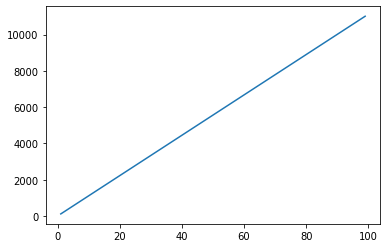

In [41]:
x = range(1, 100)
y = []
for i in range(1, 100):
    p = t.distributions.Normal(t.zeros(10), 1.0)
    y.append(i*t.distributions.kl_divergence(q, p).sum())
plt.plot(x,y)    

In [56]:
p1 = t.distributions.Normal(t.zeros(1), 1.0)
k1 = t.distributions.kl_divergence(q, p1).sum() 

p2 = t.distributions.Normal(t.zeros(1), 0.1)
k2 = t.distributions.kl_divergence(q, p2).sum() 

k1, k2

(tensor(11.1217), tensor(1321.3901))

In [48]:
q

Normal(loc: tensor([-0.3448]), scale: tensor([5.1379]))

In [65]:
# KL = 1.0
(5.13**2 +0.34**2-1-np.log(5.13**2))/2, 100*((5.13**2 +0.34**2-1-np.log(5.13**2))/2)

(11.081144340817323, 1108.1144340817323)

In [67]:
# KL = 0.1
(100*5.13**2 +100*0.34**2-1-np.log((5.13)**2))/2 + 7 # 7?

1319.4898943408173

In [11]:
t.manual_seed(0)
for lam in [100.0]:
    for start in range(1):                    
            net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x))
            
            net = net.to(device)
            optim = t.optim.Adam(net.parameters(), lr=5e-4)
            loss_fn = nn.CrossEntropyLoss().to(device)            
            for e in range(epoch_num):
                label = 'lambda {}, epoch {}: '.format(lam, e)                
                utils.train_batches_net(train_loader,len(train_data),  net, device, loss_fn, optim, t.tensor(lam), label, rep=False)
                if e%5 == 0:
                    print (utils.test_acc_net(net, device, test_loader))
            

lambda 100.0, epoch 1: 160.28186:   1%|▏         | 3/235 [00:00<00:07, 29.54it/s]

0.8273


lambda 100.0, epoch 6: 125.972916:   1%|▏         | 3/235 [00:00<00:07, 29.46it/s]

0.9031


lambda 100.0, epoch 11: 92.51573:   1%|▏         | 3/235 [00:00<00:07, 29.64it/s]

0.8839


lambda 100.0, epoch 16: 62.587524:   1%|▏         | 3/235 [00:00<00:07, 29.47it/s]

0.8622


lambda 100.0, epoch 17: 54.85046:  94%|█████████▎| 220/235 [00:07<00:00, 29.29it/s] 


KeyboardInterrupt: 

In [ ]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    

net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        
        net.load_state_dict(t.load(os.path.join(path_to_save, 'rep_net_lam_{}_start_{}.cpk'.format(lam, s))))        
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_rep.json'),'w') as out:
    out.write(json.dumps(lam_results))  

0.001 0
0.001 1
0.001 2


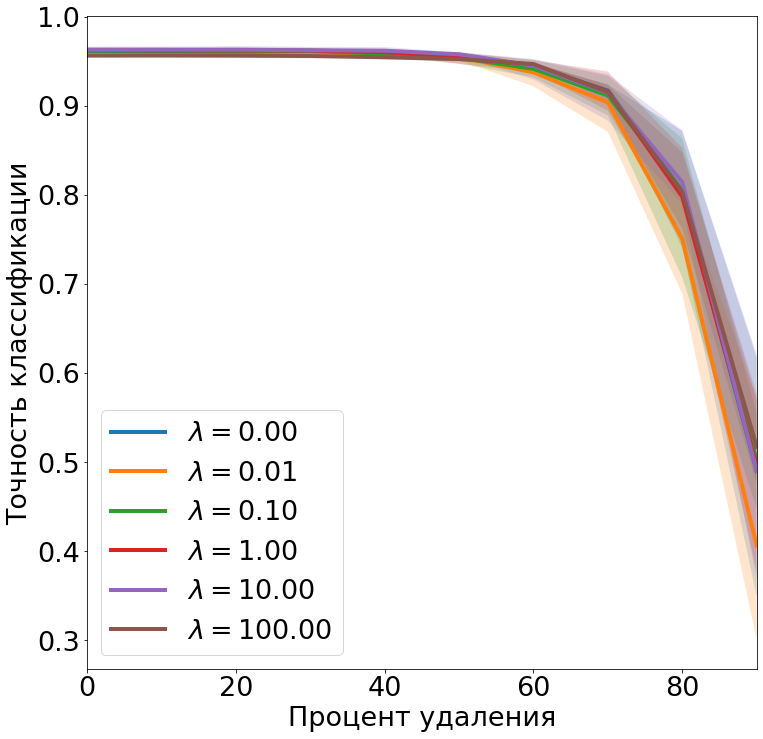

In [9]:
with open(os.path.join(path_to_save, 'results_rep.json'),'r') as inp:
    lam_results = json.loads(inp.read())
    lam_results = {float(k):lam_results[k] for k in lam_results} 
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Rep')
#plt.show()
